In [1]:
from glob import glob
import os
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
import matplotlib.ticker as ticker
from matplotlib.collections import Collection, LineCollection
from matplotlib.artist import allow_rasterization
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as md
import matplotlib.ticker as ticker
from metpy.plots import ctables
#from pyPIPS import disdrometer_module as dis
from pyPIPS import pips_io as pipsio
from pyPIPS import timemodule as tm
from pyPIPS.utils import mtokm, getTimeWindow, interp_along_1D
from pyPIPS import plotmodule as pm
from pyPIPS import PIPS as pips
from pyPIPS import fmcw
from itertools import cycle
import netCDF4 as netcdf
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from skimage.restoration import unwrap_phase
import skimage.feature as SF
import numpy.ma as ma
from scipy import ndimage, interpolate
import pyart
import cartopy.crs as ccrs
%load_ext autoreload
%autoreload 2
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Read in PIPS data
PIPS_data_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/full_PIPS_dataset/'
PIPS_filename = 'parsivel_combined_FMCW_2017_032717_PIPS2A_60s.nc'
PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
PIPS_ds = xr.open_dataset(PIPS_filepath)
print(PIPS_ds)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:                  (diameter_bin: 32, fallspeed_bin: 32, parameter: 3, time: 1441)
Coordinates:
  * time                     (time) datetime64[ns] 2017-03-27 ... 2017-03-28
    fallspeed                (fallspeed_bin) float64 ...
    diameter                 (diameter_bin) float64 ...
    min_diameter             (diameter_bin) float64 ...
    max_diameter             (diameter_bin) float64 ...
    min_fallspeeds           (fallspeed_bin) float64 ...
    max_fallspeeds           (fallspeed_bin) float64 ...
  * parameter                (parameter) object 'N0' 'lamda' 'alpha'
Dimensions without coordinates: diameter_bin, fallspeed_bin
Data variables:
    precipintensity          (time) float64 ...
    precipaccum              (time) float64 ...
    parsivel_dBZ             (time) float64 ...
    pcount                   (time) int64 ...
    signal_amplitude         (time) float64 ...
    pvoltage                 (time) float64 ...
    sensor_temp              (

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/netCDF4_.py:372: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  attributes = {k: var.getncattr(k) for k in var.ncattrs()}
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/xarray/backends/n

In [7]:
radar_starttimestamp = '201703271900'
radar_endtimestamp = '201703272200'

radar_startdatetime = datetime.strptime(radar_starttimestamp, '%Y%m%d%H%M')
radar_enddatetime = datetime.strptime(radar_endtimestamp, '%Y%m%d%H%M')

radar_basedir = \
    '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/NEXRAD/PIPS2A_FMCW/0327/HTX'
level2_dir = os.path.join(radar_basedir, 'level2')
level2_files = sorted(glob(level2_dir + '/*.ar2v'))

level2_files_to_read = []
for level2_file in level2_files:
    radar_file_timestamp = os.path.basename(level2_file)[4:19]
    radar_file_datetime = datetime.strptime(radar_file_timestamp, '%Y%m%d_%H%M%S')
    if radar_file_datetime >= radar_startdatetime and radar_file_datetime <= radar_enddatetime:
        level2_files_to_read.append(level2_file)
        print(os.path.basename(level2_file))

gridded_output_dir = os.path.join(radar_basedir, 'gridded_new')
if not os.path.exists(gridded_output_dir):
    os.makedirs(gridded_output_dir)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KHTX20170327_190101_V06.ar2v
KHTX20170327_190505_V06.ar2v
KHTX20170327_190923_V06.ar2v
KHTX20170327_191334_V06.ar2v
KHTX20170327_191743_V06.ar2v
KHTX20170327_192200_V06.ar2v
KHTX20170327_192614_V06.ar2v
KHTX20170327_193038_V06.ar2v
KHTX20170327_193521_V06.ar2v
KHTX20170327_193938_V06.ar2v
KHTX20170327_194415_V06.ar2v
KHTX20170327_194850_V06.ar2v
KHTX20170327_195343_V06.ar2v
KHTX20170327_195838_V06.ar2v
KHTX20170327_200335_V06.ar2v
KHTX20170327_200845_V06.ar2v
KHTX20170327_201354_V06.ar2v
KHTX20170327_201905_V06.ar2v
KHTX20170327_202409_V06.ar2v
KHTX20170327_202905_V06.ar2v
KHTX20170327_203408_V06.ar2v
KHTX20170327_204117_V06.ar2v
KHTX20170327_204607_V06.ar2v
KHTX20170327_205103_V06.ar2v
KHTX20170327_205552_V06.ar2v
KHTX20170327_210043_V06.ar2v
KHTX20170327_210542_V06.ar2v
KHTX20170327_211031_V06.ar2v
KHTX20170327_211542_V06.ar2v
KHTX20170327_212051_V06.ar2v
KHTX20170327_212541_V06.ar2v
KHTX20170327_213033_V06.ar2v
KHTX20170327_213525_V06.ar2v
KHTX20170327_214014_V06.ar2v
KHTX20170327_2

In [4]:
# Set up grid limits and spacing

xmin = -123000.
xmax = 123000.
dx = 1000.
nx = int((xmax - xmin) / dx) + 1

ymin = -123000.
ymax = 123000.
dy = 1000.
ny = int((ymax - ymin) / dy) + 1

zmin = 500.
zmax = 4500.
dz = 100.
nz = int((zmax - zmin) / dz) + 1
print(nz)

41


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Test first radar file

print(level2_files_to_read[0])

radar = pyart.io.read_nexrad_archive(level2_files_to_read[0])

grid = pyart.map.grid_from_radars(
    (radar,),
    grid_shape=(nz, ny, nx),
    grid_limits=((zmin, zmax), (ymin, ymax), (xmin, xmax)),
    fields=['differential_reflectivity', 'reflectivity', 'cross_correlation_ratio'],
    weighting_function='Barnes2')

grid_xr = grid.to_xarray()
print(grid_xr)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/NEXRAD/PIPS2A_FMCW/0327/HTX/level2/KHTX20170327_190101_V06.ar2v
<xarray.Dataset>
Dimensions:                    (time: 1, x: 247, y: 247, z: 41)
Coordinates:
  * time                       (time) object 2017-03-27 19:01:01.806000
  * z                          (z) float64 500.0 600.0 700.0 ... 4.4e+03 4.5e+03
    lat                        (y) float64 33.82 33.83 33.84 ... 36.02 36.03
    lon                        (x) float64 -87.41 -87.4 -87.39 ... -84.76 -84.75
  * y                          (y) float64 -1.23e+05 -1.22e+05 ... 1.23e+05
  * x                          (x) float64 -1.23e+05 -1.22e+05 ... 1.23e+05
Data variables:
    differential_reflectivity  (time, z, y, x) float32 nan nan nan ... nan nan
    reflectivity               (time, z, y, x) float32 nan nan nan ... nan nan
    cross_correlation_ratio    (time, z, y, x) float32 nan nan nan ... nan nan
    ROI                        (time, z, y, x) float32 

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


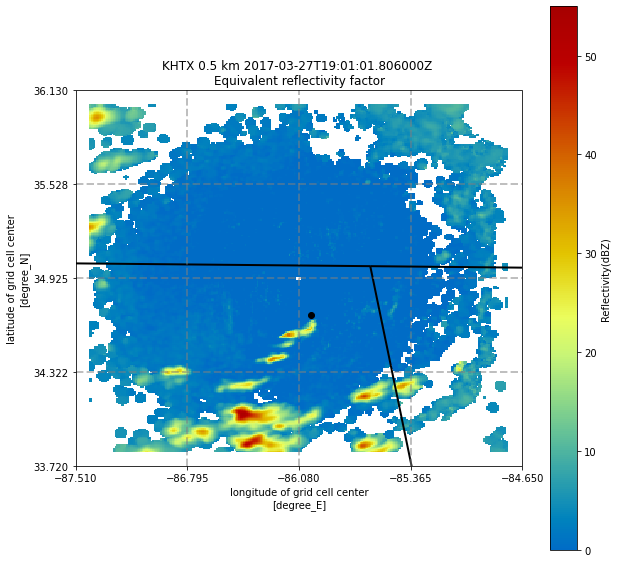

In [9]:
display = pyart.graph.GridMapDisplay(grid)

# create the plot
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=projection)

#ax.imshow(grid.fields['REF']['data'][0], origin='lower')
display.plot_grid('reflectivity', 0, vmin=0, vmax=55, projection=projection, cmap="pyart_HomeyerRainbow", ax=ax)
#plt.xlim(-86.7, -85.3)
#plt.ylim(34.0, 36.0)
#start_time = '2017-04-30T20:45'
#end_time = '2017-04-30T20:45'
#plt.title('HTX Time {}'.format(start_time))

# Read in the file, create a RadarMapDisplay object
# fmcw_data_dir = '/Users/terrell8/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/FMCW/0430'

# Indicate the radar location with a point
FMCW_lat = 34.6872
FMCW_lon = -86.005
ax.plot([FMCW_lon], [FMCW_lat], color='black', marker='o', transform=ccrs.PlateCarree())


In [10]:
# Create gridded radar objects and dump to disk
for i, f in enumerate(level2_files_to_read):
    print("On file {:d} of {:d} ({:.2f}%)".format(i+1, len(level2_files), (i+1)/len(level2_files)*100.))
    print("Reading {}".format(os.path.basename(f)))
    radar = pyart.io.read_nexrad_archive(f)
    output_file = os.path.basename(f)[:-5]+"_gridded.nc"
    output_path = os.path.join(gridded_output_dir, output_file)
    
    print("Mapping to grid!")
    grid = pyart.map.grid_from_radars(
        (radar,),
        grid_shape=(nz, ny, nx),
        grid_limits=((zmin, zmax), (ymin, ymax), (xmin, xmax)),
        fields=['differential_reflectivity', 'reflectivity', 'cross_correlation_ratio'],
        weighting_function='Barnes2')
    print("Writing {}".format(output_file))
    pyart.io.write_grid(output_path, grid, arm_time_variables=True, arm_alt_lat_lon_variables=True, 
                        write_point_x_y_z=True, write_point_lon_lat_alt=True)

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


On file 1 of 245 (0.41%)
Reading KHTX20170327_190101_V06.ar2v
Mapping to grid!
Writing KHTX20170327_190101_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 2 of 245 (0.82%)
Reading KHTX20170327_190505_V06.ar2v
Mapping to grid!
Writing KHTX20170327_190505_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 3 of 245 (1.22%)
Reading KHTX20170327_190923_V06.ar2v
Mapping to grid!
Writing KHTX20170327_190923_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 4 of 245 (1.63%)
Reading KHTX20170327_191334_V06.ar2v
Mapping to grid!
Writing KHTX20170327_191334_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 5 of 245 (2.04%)
Reading KHTX20170327_191743_V06.ar2v
Mapping to grid!
Writing KHTX20170327_191743_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 6 of 245 (2.45%)
Reading KHTX20170327_192200_V06.ar2v
Mapping to grid!
Writing KHTX20170327_192200_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 7 of 245 (2.86%)
Reading KHTX20170327_192614_V06.ar2v
Mapping to grid!
Writing KHTX20170327_192614_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 8 of 245 (3.27%)
Reading KHTX20170327_193038_V06.ar2v
Mapping to grid!
Writing KHTX20170327_193038_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 9 of 245 (3.67%)
Reading KHTX20170327_193521_V06.ar2v
Mapping to grid!
Writing KHTX20170327_193521_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 10 of 245 (4.08%)
Reading KHTX20170327_193938_V06.ar2v
Mapping to grid!
Writing KHTX20170327_193938_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 11 of 245 (4.49%)
Reading KHTX20170327_194415_V06.ar2v
Mapping to grid!
Writing KHTX20170327_194415_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 12 of 245 (4.90%)
Reading KHTX20170327_194850_V06.ar2v
Mapping to grid!
Writing KHTX20170327_194850_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 13 of 245 (5.31%)
Reading KHTX20170327_195343_V06.ar2v
Mapping to grid!
Writing KHTX20170327_195343_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 14 of 245 (5.71%)
Reading KHTX20170327_195838_V06.ar2v
Mapping to grid!
Writing KHTX20170327_195838_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 15 of 245 (6.12%)
Reading KHTX20170327_200335_V06.ar2v
Mapping to grid!
Writing KHTX20170327_200335_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 16 of 245 (6.53%)
Reading KHTX20170327_200845_V06.ar2v
Mapping to grid!
Writing KHTX20170327_200845_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 17 of 245 (6.94%)
Reading KHTX20170327_201354_V06.ar2v
Mapping to grid!
Writing KHTX20170327_201354_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 18 of 245 (7.35%)
Reading KHTX20170327_201905_V06.ar2v
Mapping to grid!
Writing KHTX20170327_201905_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 19 of 245 (7.76%)
Reading KHTX20170327_202409_V06.ar2v
Mapping to grid!
Writing KHTX20170327_202409_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 20 of 245 (8.16%)
Reading KHTX20170327_202905_V06.ar2v
Mapping to grid!
Writing KHTX20170327_202905_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 21 of 245 (8.57%)
Reading KHTX20170327_203408_V06.ar2v
Mapping to grid!
Writing KHTX20170327_203408_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 22 of 245 (8.98%)
Reading KHTX20170327_204117_V06.ar2v
Mapping to grid!
Writing KHTX20170327_204117_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 23 of 245 (9.39%)
Reading KHTX20170327_204607_V06.ar2v
Mapping to grid!
Writing KHTX20170327_204607_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 24 of 245 (9.80%)
Reading KHTX20170327_205103_V06.ar2v
Mapping to grid!
Writing KHTX20170327_205103_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 25 of 245 (10.20%)
Reading KHTX20170327_205552_V06.ar2v
Mapping to grid!
Writing KHTX20170327_205552_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 26 of 245 (10.61%)
Reading KHTX20170327_210043_V06.ar2v
Mapping to grid!
Writing KHTX20170327_210043_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 27 of 245 (11.02%)
Reading KHTX20170327_210542_V06.ar2v
Mapping to grid!
Writing KHTX20170327_210542_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 28 of 245 (11.43%)
Reading KHTX20170327_211031_V06.ar2v
Mapping to grid!
Writing KHTX20170327_211031_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 29 of 245 (11.84%)
Reading KHTX20170327_211542_V06.ar2v
Mapping to grid!
Writing KHTX20170327_211542_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 30 of 245 (12.24%)
Reading KHTX20170327_212051_V06.ar2v
Mapping to grid!
Writing KHTX20170327_212051_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 31 of 245 (12.65%)
Reading KHTX20170327_212541_V06.ar2v
Mapping to grid!
Writing KHTX20170327_212541_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 32 of 245 (13.06%)
Reading KHTX20170327_213033_V06.ar2v
Mapping to grid!
Writing KHTX20170327_213033_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 33 of 245 (13.47%)
Reading KHTX20170327_213525_V06.ar2v
Mapping to grid!
Writing KHTX20170327_213525_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 34 of 245 (13.88%)
Reading KHTX20170327_214014_V06.ar2v
Mapping to grid!
Writing KHTX20170327_214014_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 35 of 245 (14.29%)
Reading KHTX20170327_214507_V06.ar2v
Mapping to grid!
Writing KHTX20170327_214507_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 36 of 245 (14.69%)
Reading KHTX20170327_214959_V06.ar2v
Mapping to grid!
Writing KHTX20170327_214959_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 37 of 245 (15.10%)
Reading KHTX20170327_215447_V06.ar2v
Mapping to grid!
Writing KHTX20170327_215447_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)


On file 38 of 245 (15.51%)
Reading KHTX20170327_215957_V06.ar2v
Mapping to grid!
Writing KHTX20170327_215957_V06_gridded.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.8/site-packages/pyart/io/common.py:71: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  carr = netCDF4.stringtochar(arr)
